In [1]:
# 使用jupyter notebook 要加：
%matplotlib inline

import requests
import pandas as pd
import json
import numpy as np
# conda install seaborn
import seaborn as sns
import crawl_price

In [2]:
# 1.爬蟲國際股市，建立國際股市對照表
url = "https://finance.yahoo.com/world-indices/"
response = requests.get(url)

import io
# 2.用IO表示虛擬EXCEL檔案，建立國際股市對照表
f = io.StringIO(response.text)
dfs = pd.read_html(f)
world_index = dfs[0]

In [9]:
# 用dict型態抓取全球各指數收盤價
import time
world_index_history = {}
# 3.用國際股市對照表建立個股江波圖
for symbol, name in zip(world_index['Symbol'], world_index['Name']):  
    print(name)
    world_index_history[name] = crawl_price.crawl_price(symbol)
    # time.sleep(1)


S&P 500
Dow 30
Nasdaq
NYSE COMPOSITE (DJ)
NYSE AMEX COMPOSITE INDEX
Cboe UK 100 Price Return
Russell 2000
Vix
FTSE 100
DAX PERFORMANCE-INDEX
CAC 40
ESTX 50 PR.EUR
EURONEXT 100
BEL 20
MOEX Russia Index
Nikkei 225
HANG SENG INDEX
SSE Composite Index
STI Index
S&P/ASX 200
ALL ORDINARIES
S&P BSE SENSEX
Jakarta Composite Index
FTSE Bursa Malaysia KLCI
S&P/NZX 50 INDEX GROSS
KOSPI Composite Index
TSEC weighted index
S&P/TSX Composite index
IBOVESPA
IPC MEXICO
S&P/CLX IPSA
MERVAL
TA-125
EGX 30 Price Return Index


KeyError: 'timestamp'

In [49]:
# 4.多股收盤價表
close = {}
for name, price in world_index_history.items():
    if price.index.is_unique:
        close[name] = price['close']  
close = pd.DataFrame(close)

# 5.算獲利=>sharpe ratio
pct_change = close.pct_change()
profit = pct_change.rolling(252).mean()
risk = pct_change.rolling(252).std()
sharpe = profit / risk * (252 ** 0.5)
# sharpe
# print(sharpe['S&P 500'])

,S&P 500,Dow 30,Nasdaq,NYSE COMPOSITE (DJ),NYSE AMEX COMPOSITE INDEX,Cboe UK 100 Price Return,Russell 2000,Vix,FTSE 100,DAX PERFORMANCE-INDEX,...,FTSE Bursa Malaysia KLCI,S&P/NZX 50 INDEX GROSS,KOSPI Composite Index,TSEC weighted index,S&P/TSX Composite index,IBOVESPA,IPC MEXICO,S&P/CLX IPSA,MERVAL,TA-125
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-30,0.173028,0.300152,0.178767,-0.131646,0.035393,-0.297689,-0.165704,0.447830,-0.325130,-0.628931,...,-1.022612,0.774327,-0.755921,-0.651215,0.204393,0.735288,-0.612208,-0.385203,0.502769,0.661795
2019-01-31,0.175404,0.214892,0.198096,-0.123226,0.036724,-0.260069,-0.155756,0.469090,-0.292484,-0.708913,...,-1.046883,0.777390,-0.755874,-0.638909,0.234928,0.743942,-0.592156,-0.383656,0.523661,0.590355
2019-02-01,0.201656,0.266375,0.210173,-0.080754,-0.024662,-0.211380,-0.113631,0.496708,-0.236080,-0.720296,...,-1.019012,0.777390,-0.802105,-0.645597,0.207979,0.832916,-0.626640,-0.289806,0.582140,0.590355


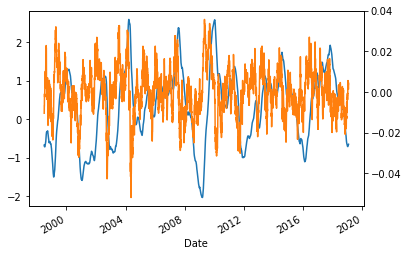

In [23]:
# 6.平滑化sharpe，sr為夏普指數，srsma是60日ma，diff是斜率
d = 60
sr = sharpe['TSEC weighted index'].dropna()
srsma = sr.rolling(d).mean()
srsmadiff = srsma.diff()
srsma.plot()
srsmadiff.plot(secondary_y=True)

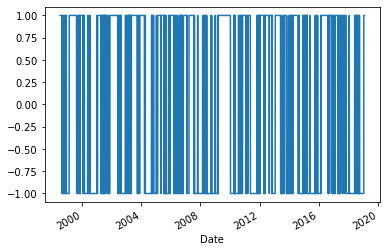

In [34]:
# 7.策略的核心，斜率轉正=>夏普轉正=>股市大漲。反之亦然。
buy = (srsmadiff > 0) & (srsmadiff.shift() < 0)
sell = (srsmadiff < 0) & (srsmadiff.shift() > 0)

# 8.畫交易次數
hold = pd.Series(np.nan, index=buy.index)
hold[buy] = 1
hold[sell] = -1
hold.ffill(inplace=True)
hold.plot()
# (buy * 1).plot()
# (sell * -1).plot()

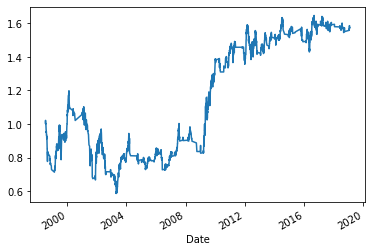

In [48]:
twii = close['TSEC weighted index'][buy.index]
# print(twii)
pct_change_earn = twii.pct_change()
# print(pct_change_earn)
pct_ratio = (pct_change_earn.shift(-1)+1) # 今天到明天的價格變化
# print(pct_ratio)
pct_ratio.fillna(1)[hold == 1].cumprod().plot()